# Прикладные задачи анализа данных

## Домашнее задание 4

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [2]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [3]:
ratings = pd.read_csv('music_dataset (1).csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [4]:
tracks_info = pd.read_csv('tracks_info (1).csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (0.5 балла).** Реализуйте метрику $MAP@k$.

In [5]:
def precisionk(relevant: List[int], predicted: List[int], k: int = 20):
  return 1/k * np.sum([predicted[i] in relevant for i in range(k)])

def apk(relevant: List[int], predicted: List[int], k: int = 20):
    return 1/min(k, len(relevant)) * np.sum([(predicted[i] in relevant) * precisionk(relevant, predicted, i + 1) for i in range(k)])

def mapk(relevant: List[List[int]], predicted: List[List[int]], k: int = 20):
    n = len(relevant)
    return 1/n * np.sum([apk(relevant[i], predicted[i], k) for i in range(n)])

In [6]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [7]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [8]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [9]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [10]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [11]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [12]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [13]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [14]:
test_relevant = []
test_users = []
for user_id, user_data in test_ratings.groupby('userId'):
    test_relevant += [user_data['trackId'].tolist()]
    test_users.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [15]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.user_ids = np.unique(self.ratings['userId'])
        self.n_users = len(np.unique(self.ratings['userId']))
        self.n_items = len(np.unique(self.ratings['trackId']))

        self.R = np.zeros((self.n_users, self.n_items))
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1.
        
    def recommend(self, uid: int):
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]

        return new_preds

    def get_test_recommendations(self, k: int):
        return self.remove_train_items([self.recommend(uid) for uid in self.user_ids], k)

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (0.5 балла).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [29]:
def pearson(ratings: np.array, user_vector: np.array) -> np.array:
  # ratings: num_users x num_tracks прослушал/нет 
  # user_vector: num_tracks x 1 - просулшал/нет
  return ratings.dot(user_vector)/(np.sqrt(np.sum(ratings * ratings, axis = 1))*np.sqrt(user_vector.dot(user_vector.T)))


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
  # ratings: num_users x num_tracks прослушал/нет 
  # user_vector: num_tracks x 1 - просулшал/нет
  return ratings.dot(user_vector) / np.sum(np.logical_or(ratings, user_vector).astype(int), axis = 1)

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [30]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func):
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = 0.02

    def similarity(self, user_vector: np.array):
        """
        user_vector: [n_items]
        returns N(u) based of self.Ratings
        """
        similarity_vector = self.similarity_func(self.R, user_vector)
        # зачем рекомендовать человеку то, что слушают люди 
        # с абсолютно таким же вкусом, как у него 
        # ответ: для того, чтобы не ловить zero division на рекомендации
        return self.R[(similarity_vector > self.alpha)] # * (similarity_vector != 1)

    def recommend(self, uid: int):
      user = self.R[uid]
      N_u = self.similarity(user)
      similarity_vector = self.similarity_func(N_u, user)
      r_hat = similarity_vector.dot(N_u)/np.sum(np.abs(similarity_vector))
      return np.argsort(-r_hat)

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [19]:
%%time
u2u_jaccard = User2User(train_ratings, jaccard)

mapk_history_jaccard = []
k_grid = [1,3,5,8,10,20,40,60,100]

for k in k_grid:
  mapk_history_jaccard.append(mapk(test_relevant, u2u_jaccard.get_test_recommendations(k), k))

mapk_history_jaccard

CPU times: user 4min 47s, sys: 4min 11s, total: 8min 58s
Wall time: 5min 10s


[0.0,
 0.002955082742316785,
 0.0024113475177304964,
 0.002301798378926038,
 0.002191320499831138,
 0.0018307535440794116,
 0.0017268471407077852,
 0.0017922675026412736,
 0.0018775284339849433]

In [31]:
%%time
u2u_pearson = User2User(train_ratings, pearson)

mapk_history_pearson = []
k_grid = [1,3,5,8,10,20,40,60,100]

for k in k_grid:
  mapk_history_pearson.append(mapk(test_relevant, u2u_pearson.get_test_recommendations(k), k))

mapk_history_pearson

CPU times: user 3min 44s, sys: 4min 17s, total: 8min 2s
Wall time: 4min 50s


[0.00425531914893617,
 0.002364066193853428,
 0.0014184397163120566,
 0.0015165906788247214,
 0.0013456602499155692,
 0.0008269603605961554,
 0.0006908305274841157,
 0.0007895207126255904,
 0.0009159255051378353]

In [32]:
%time 
mapk_history_popular = []
k_grid = [1,3,5,8,10,20,40,60,100]
most_popular_tracks = np.argsort(-np.bincount(train_ratings['trackId']))

for k in k_grid:
  mapk_history_popular.append(mapk(test_relevant, [most_popular_tracks[:k] for u in test_users], k))

mapk_history_popular

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.82 µs


[0.0,
 0.0,
 0.00021276595744680854,
 0.00013297872340425532,
 0.0002765957446808511,
 0.0005034061216871967,
 0.00038665828056485825,
 0.00041923456978703075,
 0.000525593637144424]

In [33]:
%time 
mapk_history_random = []
k_grid = [1,3,5,8,10,20,40,60,100]
all_tracks = pd.unique(tracks_info['id'])

for k in k_grid:
  mapk_history_random.append(mapk(test_relevant, [np.random.choice(all_tracks, k, replace = False) for u in test_users], k))

mapk_history_random

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 8.11 µs


[0.0,
 0.0,
 0.0,
 0.0,
 0.00021276595744680854,
 0.00013297872340425532,
 3.2890567605013296e-05,
 2.2092221469016833e-05,
 3.345891231111663e-05]

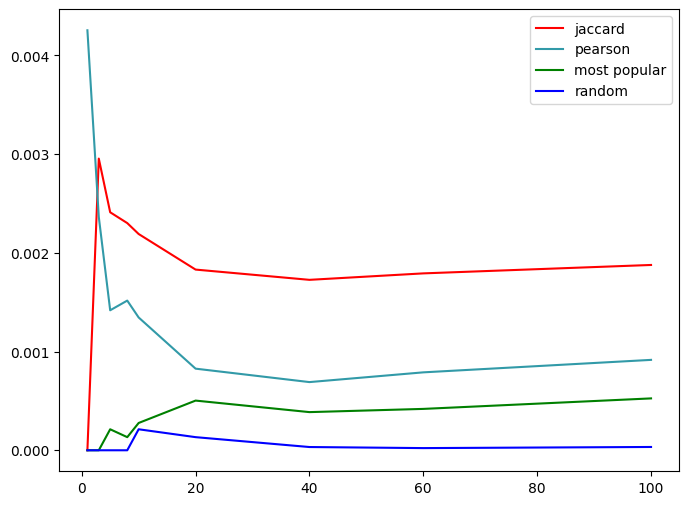

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6), dpi = 100)

plt.plot(k_grid, mapk_history_jaccard, color='r', label='jaccard')
plt.plot(k_grid, mapk_history_pearson, color='#329aa8', label='pearson')
plt.plot(k_grid, mapk_history_popular, color='g', label='most popular')
plt.plot(k_grid, mapk_history_random, color='b', label='random')

plt.legend()

fig.show()

**Задание 6 (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [42]:
model = u2u_jaccard

In [43]:
user_id = np.random.randint(0, model.n_users)

In [45]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')

tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
3,Imma Be,['Black Eyed Peas']
63,When I Grow Up,['The Pussycat Dolls']
65,Jai Ho! (You Are My Destiny),"['A.R.Rahman', 'The Pussycat Dolls', 'Nicole S..."
103,Right Now (Na Na Na),['Akon']
113,Just A Lil Bit,['50 Cent']
134,Need A Boss,"['Shareefa', 'Ludacris']"
213,Cuidar Nuestro Amor,['David Bisbal']
243,P.I.M.P.,['50 Cent']
277,Wait A Minute,"['The Pussycat Dolls', 'Timbaland']"
281,London Bridge,['Fergie']


In [46]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')

tracks_info.loc[preds[user_id]][['name', 'artists']]

Predicted tracks:


,name,artists
52701,Прятки,['HammAli & Navai']
2814,Numb,['Linkin Park']
64683,I WANNA BE YOUR SLAVE,['Måneskin']
35064,Thunder,['Imagine Dragons']
8263,Shape Of My Heart,['Sting']
62418,Снова я напиваюсь,['SLAVA MARLOW']
51525,Прочь,"['TERNOVOY', 'AMCHI']"
59685,X.O,"['Andro', 'The Limba']"
53671,2 типа людей,['Макс Корж']
59229,Мальчик на девятке,['DEAD BLONDE']


In [47]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')

tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
67163,Солнце Монако,['Люся Чеботина']
67178,МАЛИНОВАЯ ЛАДА,['GAYAZOV$ BROTHER$']
67179,Космос,['Ёлка']
67186,ЧЕ ЗА ЛЕВ ЭТОТ ТИГР,['Gazan']
67206,Потеряли пацана,['Tanir & Tyomcha']
67210,Как дети,['ERSHOV']
67213,Танцевали до утра,['Лёша Свик']
67214,Я так люблю тебя,['Artik & Asti']
67231,Оставаться человеком,['Анет Сай']
67251,Ты должна рядом быть,"['Мари Краймбрери', 'MOT']"


### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_u \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 7 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастческим градинтным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

**SGD:**

$\nabla_{p_u}\left[\sum_{u, i}\left(\left\langle p_u, q_i\right\rangle - r_{u i}\right)^2 + \lambda\left(\sum_{u \in U}\left\|p_u\right\|^2+\sum_{i \in I}\left\|q_i\right\|^2\right)\right]=\sum_i 2\left(\left\langle p_u, q_i\right\rangle - r_{u i}\right) q_i + 2 \lambda p_u$

$p_u \leftarrow p_u - \eta \nabla_{p_u}$

$p_u \leftarrow p_u - 2\eta(\sum_i(\langle p_u, q_i\rangle - r_{ui})q_i + \lambda p_u)$

$P \leftarrow P - 2\eta ((P^TQQ^T - RQ^T)^T + \lambda P) = P - 2\eta (QQ^TP - QR^T + \lambda P)$

аналогично:

$Q \leftarrow Q - 2\eta ((Q^TPP^T - R^TP^T)^T + \lambda Q) = Q - 2\eta (PP^TQ - PR + \lambda Q) $

**ALS:**

$\nabla_{p_u}\left[\sum_{u, i}\left(\left\langle p_u, q_i\right\rangle - r_{u i}\right)^2 + \lambda\left(\sum_{u \in U}\left\|p_u\right\|^2+\sum_{i \in I}\left\|q_i\right\|^2\right)\right]=\sum_i 2\left(\left\langle p_u, q_i\right\rangle - r_{u i}\right) q_i + 2 \lambda p_u=0$

$\sum_i \left(\left\langle p_u, q_i\right\rangle - r_{u i}\right) q_i + \lambda p_u=0$

$\sum_i (p_u^Tq_iq_i) - \sum_i r_{u i}q_i + \lambda p_u=0$

$(\sum_i q_iq_i^T)p_u - \sum_i r_{u i}q_i + \lambda p_u=0$

$p_u = \frac{\sum_i q_i r_{ui}}{[\sum_i q_i q_i^T] + \lambda}$

$P = \frac{1}{tr(Q^TQ) + \lambda}QR^T$

аналогично:

$Q = \frac{1}{tr(P^TP) + \lambda}PR$


**Задание 8 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [64]:
class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd', lamb = 0.01):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode

        self.P = np.random.normal(size=(dim, self.n_users,))
        self.Q = np.random.normal(size=(dim, self.n_items,))

        self.lr = 0.0002
        self.lamb = lamb
        self.eps = 10e-7

    def fit(self, num_iters=5):
        previous_loss = 0
        for epoch in tqdm(range(num_iters)):

            if self.mode == 'sgd':
                grad_p = self.Q.dot((self.P.T.dot(self.Q)*self.R - self.R).T) + self.lamb*self.P
                grad_q = self.P.dot(self.P.T.dot(self.Q)*self.R - self.R) + self.lamb*self.Q
                self.P = self.P - self.lr * 2 * grad_p
                self.Q = self.Q - self.lr * 2 * grad_q

                current_loss = np.linalg.norm(self.P.T.dot(self.Q) - self.R)**2 + self.lamb*(np.linalg.norm(self.P)**2 + np.linalg.norm(self.Q)**2)

                if(np.abs(previous_loss - current_loss)/(previous_loss + 10e-8) <= self.eps):
                  self.lr = self.lr / 2
                  self.eps = self.eps * 0.1
                  print(f'loss difference < {self.eps}, learning rate halved: {self.lr}, epsilon changed: {self.eps}')

                if(self.eps <= 10e-8):
                  print(f'epsilon < 10e-8: {self.eps}')
                  return self

                previous_loss = current_loss

            elif self.mode == 'als':
                self.P = 1/(np.trace(self.Q.dot(self.Q.T)) + self.lamb) * self.Q.dot(self.R.T)
                self.Q = 1/(np.trace(self.P.T.dot(self.P)) + self.lamb) * self.P.dot(self.R)

                current_loss = np.linalg.norm(self.P.T.dot(self.Q) - self.R)**2 + self.lamb*(np.linalg.norm(self.P)**2 + np.linalg.norm(self.Q)**2)

                if(np.abs(previous_loss - current_loss)/(previous_loss + 10e-8) <= self.eps):
                  self.lr = self.lr / 2
                  self.eps = self.eps * 0.1
                  print(f'loss difference < {self.eps}, learning rate halved: {self.lr}, epsilon changed: {self.eps}')

                if(self.lr < 10e-8):
                  print(f'learning rate < 10e-8: {self.lr}')
                  return self
                
                previous_loss = current_loss
                
            if(epoch%10 == 0):
                # print(f'p {self.P}','\n', f'q {self.Q}', '\n\n')
                  print(f'epoch: {epoch}, ' +
                        f'loss: {np.linalg.norm(self.P.T.dot(self.Q) - self.R)**2 + self.lamb*(np.linalg.norm(self.P)**2 + np.linalg.norm(self.Q)**2)}, '+ 
                        f'|P^TQ - R|: {np.linalg.norm(self.P.T.dot(self.Q) - self.R)**2 }')
            
        return self

    def recommend(self, uid):
        pred_rating = self.P.T[uid].dot(self.Q)

        return np.argsort(pred_rating)[::-1]

**Задание 9 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

In [66]:
top_score = -1
top_dim = -1
top_lfm_sgd = None
dim_grid = [5, 10, 16, 20, 25, 32, 64, 128]
lambda_grid = [0.01, 0.1, 1, 10]

for dim in dim_grid:
  for lamb in lambda_grid:
    lfm_sgd = HiddenVars(train_ratings, mode = 'sgd', dim = dim, lamb = lamb).fit(200)
    score = mapk(test_relevant, lfm_sgd.get_test_recommendations(20), 20)
    if score > top_score:
      top_score = score
      top_dim = dim
      top_lfm_sgd = lfm_sgd

dim, top_score

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 57905900.462293155, |P^TQ - R|: 57902532.85541546
epoch: 10, loss: 13649212.125353826, |P^TQ - R|: 13645869.058600418
epoch: 20, loss: 5286940.712716811, |P^TQ - R|: 5283609.131485855
epoch: 30, loss: 2350811.214259612, |P^TQ - R|: 2347485.8727446254
epoch: 40, loss: 2065165.787390721, |P^TQ - R|: 2061844.8297556804
epoch: 50, loss: 1032005.2486918463, |P^TQ - R|: 1028688.5042203411
epoch: 60, loss: 700990.5889004351, |P^TQ - R|: 697674.7771812935
epoch: 70, loss: 674622.8470542466, |P^TQ - R|: 671307.5569886514
epoch: 80, loss: 1278491.99614587, |P^TQ - R|: 1275178.6223290812
epoch: 90, loss: 991563.9815441577, |P^TQ - R|: 988255.9067971418
epoch: 100, loss: 556299.0932663623, |P^TQ - R|: 552992.2686916778
epoch: 110, loss: 536863.2760177457, |P^TQ - R|: 533556.7530072917
epoch: 120, loss: 536779.9390946694, |P^TQ - R|: 533473.6822340885
epoch: 130, loss: 538805.9043674268, |P^TQ - R|: 535499.9115760019
epoch: 140, loss: 541743.6479832927, |P^TQ - R|: 538437.9187698453

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 52921121.15263634, |P^TQ - R|: 52887415.69371259
epoch: 10, loss: 12251143.109930988, |P^TQ - R|: 12217674.993356317
epoch: 20, loss: 4201618.1997742085, |P^TQ - R|: 4168285.673543515
epoch: 30, loss: 2706120.4891780415, |P^TQ - R|: 2672886.542822012
epoch: 40, loss: 1931433.109394232, |P^TQ - R|: 1898362.025404613
epoch: 50, loss: 2000353.4686174223, |P^TQ - R|: 1967356.333667113
epoch: 60, loss: 808220.8735598704, |P^TQ - R|: 775301.7123580531
epoch: 70, loss: 682332.0100566461, |P^TQ - R|: 649446.4750238084
epoch: 80, loss: 701109.2817214224, |P^TQ - R|: 668258.3669013534
epoch: 90, loss: 639741.3350080705, |P^TQ - R|: 606924.9100431524
epoch: 100, loss: 572253.509660604, |P^TQ - R|: 539467.5931071899
epoch: 110, loss: 544237.476872932, |P^TQ - R|: 511479.2191635511
epoch: 120, loss: 537360.7734318174, |P^TQ - R|: 504629.1077224881
epoch: 130, loss: 537718.375748442, |P^TQ - R|: 505012.9786022178
epoch: 140, loss: 540391.5714409102, |P^TQ - R|: 507712.34182613745
epo

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 53728765.91202452, |P^TQ - R|: 53391951.93479107
epoch: 10, loss: 11650443.60025936, |P^TQ - R|: 11318714.182175126
epoch: 20, loss: 5452239.466721824, |P^TQ - R|: 5124139.171922271
epoch: 30, loss: 2080096.2026226798, |P^TQ - R|: 1755171.544840227
epoch: 40, loss: 1360592.4104445481, |P^TQ - R|: 1038343.2400770964
epoch: 50, loss: 1056025.857928996, |P^TQ - R|: 736390.1898931289
epoch: 60, loss: 921938.9248621596, |P^TQ - R|: 604875.0715535505
epoch: 70, loss: 863969.0357346102, |P^TQ - R|: 549450.8398478884
epoch: 80, loss: 832644.2377417835, |P^TQ - R|: 520650.38408235135
epoch: 90, loss: 808948.3447231278, |P^TQ - R|: 499454.7442957269
epoch: 100, loss: 792350.5407568594, |P^TQ - R|: 485330.96885296656
epoch: 110, loss: 783674.7890437648, |P^TQ - R|: 479104.7865526463
epoch: 120, loss: 780210.0153855251, |P^TQ - R|: 478067.90550093295
epoch: 130, loss: 779143.5417959315, |P^TQ - R|: 479409.3105699824
epoch: 140, loss: 779066.9107067331, |P^TQ - R|: 481721.2132932874

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 55513284.93485828, |P^TQ - R|: 52189981.68944446
epoch: 10, loss: 12027956.533942724, |P^TQ - R|: 8978065.605128087
epoch: 20, loss: 5895552.396644366, |P^TQ - R|: 3082718.362872901
epoch: 30, loss: 4056787.0832728376, |P^TQ - R|: 1461113.1273089778
epoch: 40, loss: 3270970.8738232995, |P^TQ - R|: 875409.802012478
epoch: 50, loss: 2840070.9830321153, |P^TQ - R|: 629105.9621242333
epoch: 60, loss: 2554760.047082494, |P^TQ - R|: 514129.636343775
epoch: 70, loss: 2339171.125340472, |P^TQ - R|: 455734.68637221254
epoch: 80, loss: 2162122.082466583, |P^TQ - R|: 423760.4558672381
epoch: 90, loss: 2009405.4128131417, |P^TQ - R|: 404937.1564888012
epoch: 100, loss: 1873907.762070213, |P^TQ - R|: 393014.7346717644
epoch: 110, loss: 1751721.9051550552, |P^TQ - R|: 384881.7506791049
epoch: 120, loss: 1640492.602440909, |P^TQ - R|: 378916.9457937927
epoch: 130, loss: 1538665.9464690296, |P^TQ - R|: 374243.5865876738
epoch: 140, loss: 1445129.3196518798, |P^TQ - R|: 370373.913540517

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 109660862.71569778, |P^TQ - R|: 109654098.4398247
epoch: 10, loss: 21899948.217476726, |P^TQ - R|: 21893231.207287375
epoch: 20, loss: 11506756.486795494, |P^TQ - R|: 11500052.891855748
epoch: 30, loss: 5830884.383357457, |P^TQ - R|: 5824195.316821269
epoch: 40, loss: 4006662.3361874754, |P^TQ - R|: 3999988.1304702954
epoch: 50, loss: 2920729.852965887, |P^TQ - R|: 2914062.3971222155
epoch: 60, loss: 1911526.2837567027, |P^TQ - R|: 1904864.525299156
epoch: 70, loss: 2643313.7876689364, |P^TQ - R|: 2636659.7693710458
epoch: 80, loss: 1997938.9432739702, |P^TQ - R|: 1991290.5969315711
epoch: 90, loss: 1990925.9640922663, |P^TQ - R|: 1984285.8072431975
epoch: 100, loss: 1735110.744691281, |P^TQ - R|: 1728477.232395835
epoch: 110, loss: 977183.8032407315, |P^TQ - R|: 970552.9903013932
epoch: 120, loss: 956510.9947614485, |P^TQ - R|: 949881.0187484092
epoch: 130, loss: 1049788.7002015973, |P^TQ - R|: 1043159.8576088855
epoch: 140, loss: 1116803.9847913007, |P^TQ - R|: 111017

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 111543741.87091242, |P^TQ - R|: 111476246.61684299
epoch: 10, loss: 21799506.85603387, |P^TQ - R|: 21732495.85164361
epoch: 20, loss: 9597603.451175498, |P^TQ - R|: 9530850.599017771
epoch: 30, loss: 5615141.702150805, |P^TQ - R|: 5548570.327003643
epoch: 40, loss: 3255037.1319872225, |P^TQ - R|: 3188587.1937152343
epoch: 50, loss: 2759631.4438325157, |P^TQ - R|: 2693315.2023258004
epoch: 60, loss: 2500297.205456827, |P^TQ - R|: 2434094.68271364
epoch: 70, loss: 1529351.2684769435, |P^TQ - R|: 1463251.4615832323
epoch: 80, loss: 2150663.065222293, |P^TQ - R|: 2084653.4069449196
epoch: 90, loss: 1407349.9629527, |P^TQ - R|: 1341446.1486338417
epoch: 100, loss: 1302675.714699357, |P^TQ - R|: 1236843.6115981056
epoch: 110, loss: 1204080.8058549946, |P^TQ - R|: 1138318.2508775245
epoch: 120, loss: 1106374.94382316, |P^TQ - R|: 1040674.9286750151
epoch: 130, loss: 1121608.7334764453, |P^TQ - R|: 1055968.8037508198
epoch: 140, loss: 1147100.9228130726, |P^TQ - R|: 1081522.800

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 114059277.3522343, |P^TQ - R|: 113387277.0803449
epoch: 10, loss: 24824505.094530687, |P^TQ - R|: 24162679.402972892
epoch: 20, loss: 10511940.945594562, |P^TQ - R|: 9857621.40117875
epoch: 30, loss: 6471330.795851424, |P^TQ - R|: 5823169.234255203
epoch: 40, loss: 3424022.15556683, |P^TQ - R|: 2781975.2791553685
epoch: 50, loss: 2943531.9142837767, |P^TQ - R|: 2306990.411448833
epoch: 60, loss: 2059671.208683397, |P^TQ - R|: 1428552.2945233898
epoch: 70, loss: 1735910.5947098604, |P^TQ - R|: 1109889.3865909989
epoch: 80, loss: 1641397.3911682465, |P^TQ - R|: 1020392.5548264466
epoch: 90, loss: 1586523.1334435632, |P^TQ - R|: 970489.9836281665
epoch: 100, loss: 1547043.2041459875, |P^TQ - R|: 935934.6661481512
epoch: 110, loss: 1522384.8360965108, |P^TQ - R|: 916153.4868690067
epoch: 120, loss: 1510006.124675103, |P^TQ - R|: 908608.2012994773
epoch: 130, loss: 1504780.2133971357, |P^TQ - R|: 908175.3131305629
epoch: 140, loss: 1503137.3290916518, |P^TQ - R|: 911286.7210

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 120345286.02999179, |P^TQ - R|: 113681812.92531183
epoch: 10, loss: 24995420.838537168, |P^TQ - R|: 18881220.37822644
epoch: 20, loss: 12144156.43781471, |P^TQ - R|: 6505403.524863474
epoch: 30, loss: 8267258.486987589, |P^TQ - R|: 3063890.7278618
epoch: 40, loss: 6595192.533893834, |P^TQ - R|: 1793000.6801459368
epoch: 50, loss: 5670509.719463463, |P^TQ - R|: 1238379.0083173579
epoch: 60, loss: 5058036.130183587, |P^TQ - R|: 967372.5215537755
epoch: 70, loss: 4598242.507947531, |P^TQ - R|: 822700.5880477972
epoch: 80, loss: 4224208.972051437, |P^TQ - R|: 739492.1381049209
epoch: 90, loss: 3904648.8065426056, |P^TQ - R|: 688340.9889330448
epoch: 100, loss: 3623473.0364730298, |P^TQ - R|: 654889.2870018258
epoch: 110, loss: 3371641.8120633876, |P^TQ - R|: 631692.8011467477
epoch: 120, loss: 3143628.9317236347, |P^TQ - R|: 614696.9433161578
epoch: 130, loss: 2935777.261846812, |P^TQ - R|: 601602.2405806369
epoch: 140, loss: 2745487.1550669605, |P^TQ - R|: 591061.779451615

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 176396824.2466272, |P^TQ - R|: 176386048.93217033
epoch: 10, loss: 36599512.26474342, |P^TQ - R|: 36588798.63987919
epoch: 20, loss: 16073794.613470165, |P^TQ - R|: 16063103.62094106
epoch: 30, loss: 9410009.72554965, |P^TQ - R|: 9399335.23184232
epoch: 40, loss: 6614476.42100497, |P^TQ - R|: 6603818.868042957
epoch: 50, loss: 5251041.323135751, |P^TQ - R|: 5240392.911370841
epoch: 60, loss: 3899402.7551760506, |P^TQ - R|: 3888767.6876008776
epoch: 70, loss: 3953288.4463788923, |P^TQ - R|: 3942664.4549414027
epoch: 80, loss: 2479827.012944909, |P^TQ - R|: 2469213.9825756047
epoch: 90, loss: 3555374.7955023446, |P^TQ - R|: 3544767.857118354
epoch: 100, loss: 3157482.2517924355, |P^TQ - R|: 3146886.5946847796
epoch: 110, loss: 2114755.439870668, |P^TQ - R|: 2104168.0192278265
epoch: 120, loss: 2410407.6389266374, |P^TQ - R|: 2399825.236385292
epoch: 130, loss: 1699553.8915142845, |P^TQ - R|: 1688975.5114248074
epoch: 140, loss: 1717872.042179147, |P^TQ - R|: 1707295.45745

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 184183236.7182788, |P^TQ - R|: 184075528.38097525
epoch: 10, loss: 39960750.6974777, |P^TQ - R|: 39853802.408859916
epoch: 20, loss: 18672477.586948376, |P^TQ - R|: 18565849.91794911
epoch: 30, loss: 9835781.049112173, |P^TQ - R|: 9729428.523551194
epoch: 40, loss: 6535812.364639697, |P^TQ - R|: 6429642.530815133
epoch: 50, loss: 5927656.980270003, |P^TQ - R|: 5821748.722671156
epoch: 60, loss: 3664090.338133455, |P^TQ - R|: 3558363.096859344
epoch: 70, loss: 3834806.7865693043, |P^TQ - R|: 3729223.499905529
epoch: 80, loss: 2462138.6746982536, |P^TQ - R|: 2356710.989048502
epoch: 90, loss: 4970406.80558655, |P^TQ - R|: 4865147.676143609
epoch: 100, loss: 2786996.1003091745, |P^TQ - R|: 2681915.977276815
epoch: 110, loss: 2489381.2056244374, |P^TQ - R|: 2384446.2396059367
epoch: 120, loss: 2694236.8209154387, |P^TQ - R|: 2589444.1500651785
epoch: 130, loss: 2199336.7847738108, |P^TQ - R|: 2094671.2539644726
epoch: 140, loss: 2235292.5976290917, |P^TQ - R|: 2130750.91739

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 172863761.48458967, |P^TQ - R|: 171787608.62575543
epoch: 10, loss: 36840979.46995714, |P^TQ - R|: 35778898.14268108
epoch: 20, loss: 17360077.44709387, |P^TQ - R|: 16308270.79413133
epoch: 30, loss: 11071660.119061755, |P^TQ - R|: 10029957.874476878
epoch: 40, loss: 6784711.286468652, |P^TQ - R|: 5752449.825588649
epoch: 50, loss: 5607158.195369957, |P^TQ - R|: 4583791.874271349
epoch: 60, loss: 4147687.648004697, |P^TQ - R|: 3133104.435699425
epoch: 70, loss: 3990314.9532831274, |P^TQ - R|: 2984363.227219145
epoch: 80, loss: 2945291.0070479866, |P^TQ - R|: 1947640.1196844801
epoch: 90, loss: 2716096.02209095, |P^TQ - R|: 1726435.436071766
epoch: 100, loss: 2625529.10979905, |P^TQ - R|: 1643780.6149988289
epoch: 110, loss: 2584721.6159393536, |P^TQ - R|: 1610834.2399497014
epoch: 120, loss: 2546398.706285645, |P^TQ - R|: 1580322.1203067205
epoch: 130, loss: 2490320.7281084163, |P^TQ - R|: 1531985.5466104366
epoch: 140, loss: 2443374.864096902, |P^TQ - R|: 1492699.16742

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 189964920.1256586, |P^TQ - R|: 179282569.74016017
epoch: 10, loss: 41974391.90015152, |P^TQ - R|: 32171254.54925281
epoch: 20, loss: 20595135.693286825, |P^TQ - R|: 11556226.595072351
epoch: 30, loss: 13994068.88716641, |P^TQ - R|: 5653144.884299961
epoch: 40, loss: 11037510.389683655, |P^TQ - R|: 3339729.311203722
epoch: 50, loss: 9379651.694798388, |P^TQ - R|: 2275110.9702105382
epoch: 60, loss: 8288118.98756512, |P^TQ - R|: 1730964.1795518657
epoch: 70, loss: 7481622.647306125, |P^TQ - R|: 1429610.591776007
epoch: 80, loss: 6837038.603996426, |P^TQ - R|: 1251214.9589080696
epoch: 90, loss: 6294758.932990345, |P^TQ - R|: 1139186.7497666322
epoch: 100, loss: 5823362.060029374, |P^TQ - R|: 1064881.1777356989
epoch: 110, loss: 5404962.8044576105, |P^TQ - R|: 1012971.9541002295
epoch: 120, loss: 5028620.543792264, |P^TQ - R|: 974878.1460952313
epoch: 130, loss: 4687170.8106645625, |P^TQ - R|: 945612.0486832064
epoch: 140, loss: 4375616.030764898, |P^TQ - R|: 922184.489756

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 212463533.62142542, |P^TQ - R|: 212450071.20323578
epoch: 10, loss: 49935918.839854114, |P^TQ - R|: 49922525.30401628
epoch: 20, loss: 20488944.753123954, |P^TQ - R|: 20475586.83761782
epoch: 30, loss: 13117392.434223117, |P^TQ - R|: 13104050.992663665
epoch: 40, loss: 9950789.832255755, |P^TQ - R|: 9937471.575051531
epoch: 50, loss: 6368453.6095630685, |P^TQ - R|: 6355155.8916625865
epoch: 60, loss: 6159542.049963878, |P^TQ - R|: 6146256.614117567
epoch: 70, loss: 4292865.390829075, |P^TQ - R|: 4279593.550894136
epoch: 80, loss: 3868132.952524948, |P^TQ - R|: 3854871.620572447
epoch: 90, loss: 3268691.108085132, |P^TQ - R|: 3255437.092961931
epoch: 100, loss: 3140151.453688223, |P^TQ - R|: 3126904.5948858727
epoch: 110, loss: 3319726.3951630075, |P^TQ - R|: 3306486.8810440404
epoch: 120, loss: 3223002.8914869395, |P^TQ - R|: 3209773.0156589826
epoch: 130, loss: 2363020.093585874, |P^TQ - R|: 2349795.986037993
epoch: 140, loss: 2490137.991453771, |P^TQ - R|: 2476917.392

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 218114278.39245424, |P^TQ - R|: 217979767.81767696
epoch: 10, loss: 46321656.958070464, |P^TQ - R|: 46187991.40260328
epoch: 20, loss: 22945880.73682997, |P^TQ - R|: 22812623.848975316
epoch: 30, loss: 12809602.000033462, |P^TQ - R|: 12676642.814510085
epoch: 40, loss: 9247863.525562337, |P^TQ - R|: 9115161.367967637
epoch: 50, loss: 6129900.767069569, |P^TQ - R|: 5997495.2936152825
epoch: 60, loss: 6871037.451768624, |P^TQ - R|: 6738831.199662116
epoch: 70, loss: 5157023.145999315, |P^TQ - R|: 5025061.383356698
epoch: 80, loss: 3585989.6032733037, |P^TQ - R|: 3454219.3706188365
epoch: 90, loss: 4126258.0845510415, |P^TQ - R|: 3994669.0188604514
epoch: 100, loss: 4041351.9622315895, |P^TQ - R|: 3909972.968445641
epoch: 110, loss: 2845655.506109183, |P^TQ - R|: 2714432.537827251
epoch: 120, loss: 3975005.8214406315, |P^TQ - R|: 3843953.6282039415
epoch: 130, loss: 2815835.2356939814, |P^TQ - R|: 2684963.466172614
epoch: 140, loss: 2458923.7910031835, |P^TQ - R|: 2328182.

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 225671340.18828905, |P^TQ - R|: 224328201.91689515
epoch: 10, loss: 51870582.86418071, |P^TQ - R|: 50545930.151266485
epoch: 20, loss: 25052339.32391645, |P^TQ - R|: 23740840.413188845
epoch: 30, loss: 16345587.25948856, |P^TQ - R|: 15046621.402563056
epoch: 40, loss: 9585579.16281666, |P^TQ - R|: 8298534.890438679
epoch: 50, loss: 7835327.056048917, |P^TQ - R|: 6559645.945015532
epoch: 60, loss: 5705987.977861125, |P^TQ - R|: 4441053.13019633
epoch: 70, loss: 5182273.799722119, |P^TQ - R|: 3928181.1712748576
epoch: 80, loss: 4245586.602992916, |P^TQ - R|: 3001850.3594478825
epoch: 90, loss: 3906244.6779837674, |P^TQ - R|: 2672734.16815274
epoch: 100, loss: 3456788.4106686483, |P^TQ - R|: 2233279.231517534
epoch: 110, loss: 3266952.4601970566, |P^TQ - R|: 2053255.2072440644
epoch: 120, loss: 3180934.8033400634, |P^TQ - R|: 1976952.0912501023
epoch: 130, loss: 3122144.345504673, |P^TQ - R|: 1927801.0239586313
epoch: 140, loss: 3058660.165726927, |P^TQ - R|: 1873873.03640

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 220707681.15707052, |P^TQ - R|: 207329334.9412898
epoch: 10, loss: 51697457.32444229, |P^TQ - R|: 39422183.58860731
epoch: 20, loss: 26789791.209650226, |P^TQ - R|: 15471811.916943789
epoch: 30, loss: 18392775.16397097, |P^TQ - R|: 7949579.7508691065
epoch: 40, loss: 14547560.290039571, |P^TQ - R|: 4909630.72638258
epoch: 50, loss: 12312674.86180259, |P^TQ - R|: 3417526.6985994116
epoch: 60, loss: 10812573.271200668, |P^TQ - R|: 2602794.1937125516
epoch: 70, loss: 9700253.55907195, |P^TQ - R|: 2122947.9212646214
epoch: 80, loss: 8816367.32398199, |P^TQ - R|: 1822757.110993071
epoch: 90, loss: 8080086.719723164, |P^TQ - R|: 1625172.8239907837
epoch: 100, loss: 7446953.771733568, |P^TQ - R|: 1489214.8250105279
epoch: 110, loss: 6890742.093580173, |P^TQ - R|: 1391861.467544068
epoch: 120, loss: 6394977.603604467, |P^TQ - R|: 1319593.7790426034
epoch: 130, loss: 5948702.318560413, |P^TQ - R|: 1264179.6574348537
epoch: 140, loss: 5544238.237645026, |P^TQ - R|: 1220456.030695

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 283469532.76050633, |P^TQ - R|: 283452708.8276407
epoch: 10, loss: 69775426.4050763, |P^TQ - R|: 69758702.5425547
epoch: 20, loss: 32487205.993267097, |P^TQ - R|: 32470529.060701262
epoch: 30, loss: 20230117.934378583, |P^TQ - R|: 20213466.236981604
epoch: 40, loss: 13337564.783557031, |P^TQ - R|: 13320935.37112079
epoch: 50, loss: 11582442.147001917, |P^TQ - R|: 11565830.69982791
epoch: 60, loss: 8228049.759304173, |P^TQ - R|: 8211455.792732759
epoch: 70, loss: 6909627.696010593, |P^TQ - R|: 6893044.866485626
epoch: 80, loss: 5816495.600097978, |P^TQ - R|: 5799928.280636351
epoch: 90, loss: 5454326.803186374, |P^TQ - R|: 5437772.517377954
epoch: 100, loss: 3994817.0305926404, |P^TQ - R|: 3978272.157961046
epoch: 110, loss: 5101103.942414618, |P^TQ - R|: 5084567.753362289
epoch: 120, loss: 3656193.1250173254, |P^TQ - R|: 3639666.4967507427
epoch: 130, loss: 3649934.1880813767, |P^TQ - R|: 3633414.156564608
epoch: 140, loss: 3772598.621572609, |P^TQ - R|: 3756086.6117805

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 275489393.2775228, |P^TQ - R|: 275321160.77132094
epoch: 10, loss: 68406186.3732625, |P^TQ - R|: 68239032.74510448
epoch: 20, loss: 32904599.936769944, |P^TQ - R|: 32738037.440593056
epoch: 30, loss: 20065109.19480453, |P^TQ - R|: 19898887.01442534
epoch: 40, loss: 14746464.475756487, |P^TQ - R|: 14580634.27328413
epoch: 50, loss: 11326658.894344399, |P^TQ - R|: 11161144.72521654
epoch: 60, loss: 8740908.903457958, |P^TQ - R|: 8575728.555643868
epoch: 70, loss: 6229245.986781949, |P^TQ - R|: 6064313.926300655
epoch: 80, loss: 5570924.394529325, |P^TQ - R|: 5406233.145764807
epoch: 90, loss: 4266835.965255729, |P^TQ - R|: 4102328.700141017
epoch: 100, loss: 4050295.1595433946, |P^TQ - R|: 3885971.7753938055
epoch: 110, loss: 4495785.155330379, |P^TQ - R|: 4331636.565162677
epoch: 120, loss: 4075443.396416335, |P^TQ - R|: 3911543.8931958345
epoch: 130, loss: 3662078.9656039937, |P^TQ - R|: 3498376.558496865
epoch: 140, loss: 3473368.6896129716, |P^TQ - R|: 3309835.4475546

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 280322544.3673601, |P^TQ - R|: 278639158.7867732
epoch: 10, loss: 65416141.98324102, |P^TQ - R|: 63756417.41499333
epoch: 20, loss: 32167174.87458759, |P^TQ - R|: 30524014.154055543
epoch: 30, loss: 19865717.40521302, |P^TQ - R|: 18237951.551444143
epoch: 40, loss: 14182825.24306401, |P^TQ - R|: 12570089.426138869
epoch: 50, loss: 10119398.018279085, |P^TQ - R|: 8520816.497179268
epoch: 60, loss: 9068110.816100046, |P^TQ - R|: 7483317.307040455
epoch: 70, loss: 6936284.824185982, |P^TQ - R|: 5364812.4647174375
epoch: 80, loss: 6685238.135501574, |P^TQ - R|: 5126937.227005796
epoch: 90, loss: 5906391.584674852, |P^TQ - R|: 4361064.203683091
epoch: 100, loss: 5441085.7118014535, |P^TQ - R|: 3908626.6371233407
epoch: 110, loss: 4910736.888210162, |P^TQ - R|: 3390797.0339071155
epoch: 120, loss: 4531148.102364654, |P^TQ - R|: 3023473.442237603
epoch: 130, loss: 4326841.539550767, |P^TQ - R|: 2831221.4417248894
epoch: 140, loss: 4229264.719400513, |P^TQ - R|: 2745570.9242653

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 287466280.35602194, |P^TQ - R|: 270734339.6848216
epoch: 10, loss: 68591948.23967159, |P^TQ - R|: 53229140.22421991
epoch: 20, loss: 35639222.41229707, |P^TQ - R|: 21474884.33601654
epoch: 30, loss: 24393967.184945583, |P^TQ - R|: 11324468.563824758
epoch: 40, loss: 19107300.701476235, |P^TQ - R|: 7045688.077143039
epoch: 50, loss: 16017067.170572203, |P^TQ - R|: 4885094.305711933
epoch: 60, loss: 13952016.90277901, |P^TQ - R|: 3677804.518665407
epoch: 70, loss: 12435922.410289552, |P^TQ - R|: 2953255.043940134
epoch: 80, loss: 11245267.019257488, |P^TQ - R|: 2493089.148059357
epoch: 90, loss: 10264631.276819337, |P^TQ - R|: 2186620.7854719865
epoch: 100, loss: 9429675.088704135, |P^TQ - R|: 1973864.8154870137
epoch: 110, loss: 8702118.70918745, |P^TQ - R|: 1820553.858574743
epoch: 120, loss: 8057830.786101635, |P^TQ - R|: 1706255.9465570294
epoch: 130, loss: 7480777.273184165, |P^TQ - R|: 1618349.1856881375
epoch: 140, loss: 6959779.517129011, |P^TQ - R|: 1548802.84981

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 355765567.25779104, |P^TQ - R|: 355744015.85444564
epoch: 10, loss: 89639410.0063745, |P^TQ - R|: 89617990.09604877
epoch: 20, loss: 46763160.55557012, |P^TQ - R|: 46741790.5700169
epoch: 30, loss: 31197432.656712424, |P^TQ - R|: 31176100.43434607
epoch: 40, loss: 21106601.863584444, |P^TQ - R|: 21085302.6740895
epoch: 50, loss: 16992622.73878914, |P^TQ - R|: 16971346.673901994
epoch: 60, loss: 14500250.58139612, |P^TQ - R|: 14478995.73169116
epoch: 70, loss: 13483283.678026961, |P^TQ - R|: 13462054.843893679
epoch: 80, loss: 10024204.058430012, |P^TQ - R|: 10002993.361924937
epoch: 90, loss: 9670279.989788784, |P^TQ - R|: 9649090.68276248
epoch: 100, loss: 8316528.772709407, |P^TQ - R|: 8295355.027359219
epoch: 110, loss: 7502383.53021712, |P^TQ - R|: 7481221.189400167
epoch: 120, loss: 6534083.865230511, |P^TQ - R|: 6512935.837449394
epoch: 130, loss: 6817413.346089964, |P^TQ - R|: 6796275.589572264
epoch: 140, loss: 6559466.084693457, |P^TQ - R|: 6538338.467039266
ep

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 365291599.03974175, |P^TQ - R|: 365075973.0461677
epoch: 10, loss: 90669146.58851635, |P^TQ - R|: 90454872.38668606
epoch: 20, loss: 47201611.62846334, |P^TQ - R|: 46987918.40515955
epoch: 30, loss: 31011936.965195846, |P^TQ - R|: 30798680.234450296
epoch: 40, loss: 21563500.346979897, |P^TQ - R|: 21350667.50755101
epoch: 50, loss: 19361326.70222868, |P^TQ - R|: 19148906.437043365
epoch: 60, loss: 14677023.553594446, |P^TQ - R|: 14465047.969560796
epoch: 70, loss: 11063403.630554294, |P^TQ - R|: 10851819.400673565
epoch: 80, loss: 9421449.030506775, |P^TQ - R|: 9210177.302766085
epoch: 90, loss: 8815063.674468365, |P^TQ - R|: 8604069.55362049
epoch: 100, loss: 7558652.957655522, |P^TQ - R|: 7347918.011274248
epoch: 110, loss: 7012167.749889425, |P^TQ - R|: 6801709.30909931
epoch: 120, loss: 6183463.486040569, |P^TQ - R|: 5973230.081777467
epoch: 130, loss: 6376377.819489563, |P^TQ - R|: 6166380.768188431
epoch: 140, loss: 6941775.327170164, |P^TQ - R|: 6732045.572473333

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 348688727.5255687, |P^TQ - R|: 346536060.4943914
epoch: 10, loss: 89498826.19221994, |P^TQ - R|: 87375081.3287678
epoch: 20, loss: 45896951.46256456, |P^TQ - R|: 43794730.714449644
epoch: 30, loss: 30707209.028469592, |P^TQ - R|: 28624262.090155385
epoch: 40, loss: 21578452.440097068, |P^TQ - R|: 19514250.167186078
epoch: 50, loss: 18390193.80308641, |P^TQ - R|: 16344175.773236826
epoch: 60, loss: 13564625.050232459, |P^TQ - R|: 11536415.153801003
epoch: 70, loss: 11110393.998286933, |P^TQ - R|: 9099169.388313172
epoch: 80, loss: 10228980.48080722, |P^TQ - R|: 8234383.252292414
epoch: 90, loss: 8693951.551616533, |P^TQ - R|: 6715735.605129315
epoch: 100, loss: 8342740.563656149, |P^TQ - R|: 6380706.156346588
epoch: 110, loss: 7392886.054350699, |P^TQ - R|: 5446830.079946271
epoch: 120, loss: 7083834.2615113435, |P^TQ - R|: 5153497.127441716
epoch: 130, loss: 6661537.896098834, |P^TQ - R|: 4746792.016417899
epoch: 140, loss: 6340465.296043051, |P^TQ - R|: 4441087.9554559

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 369009674.964226, |P^TQ - R|: 347621884.23932356
epoch: 10, loss: 89674068.17928737, |P^TQ - R|: 70034711.10199374
epoch: 20, loss: 48061339.62005773, |P^TQ - R|: 29957845.700773608
epoch: 30, loss: 33017979.188162155, |P^TQ - R|: 16314825.467348041
epoch: 40, loss: 25811133.50017838, |P^TQ - R|: 10396213.74377044
epoch: 50, loss: 21529950.54097601, |P^TQ - R|: 7303179.025655749
epoch: 60, loss: 18635371.269455023, |P^TQ - R|: 5504871.78715257
epoch: 70, loss: 16503045.412876341, |P^TQ - R|: 4384182.018524823
epoch: 80, loss: 14832814.71108294, |P^TQ - R|: 3647548.3465026114
epoch: 90, loss: 13465613.952407539, |P^TQ - R|: 3141957.1921860753
epoch: 100, loss: 12310469.573947255, |P^TQ - R|: 2782002.575971578
epoch: 110, loss: 11311961.826784093, |P^TQ - R|: 2517394.117019099
epoch: 120, loss: 10434446.869018875, |P^TQ - R|: 2317217.0228534327
epoch: 130, loss: 9653876.288979804, |P^TQ - R|: 2161784.5924242414
epoch: 140, loss: 8953316.748550896, |P^TQ - R|: 2038187.3246

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 712450629.5591891, |P^TQ - R|: 712407505.398645
epoch: 10, loss: 210870739.75469276, |P^TQ - R|: 210827827.61166984
epoch: 20, loss: 133938200.91177183, |P^TQ - R|: 133895370.65738195
epoch: 30, loss: 102327612.65939575, |P^TQ - R|: 102284847.53957888
epoch: 40, loss: 89112765.81716478, |P^TQ - R|: 89070063.2726496
epoch: 50, loss: 78618511.67833051, |P^TQ - R|: 78575878.99946903
epoch: 60, loss: 68927612.836211, |P^TQ - R|: 68885037.64691995
epoch: 70, loss: 61051947.29418462, |P^TQ - R|: 61009424.578554414
epoch: 80, loss: 56824753.6892174, |P^TQ - R|: 56782275.973753795
epoch: 90, loss: 55471819.81386332, |P^TQ - R|: 55429384.03600195
epoch: 100, loss: 50456251.32429493, |P^TQ - R|: 50413853.60874317
epoch: 110, loss: 50265160.43290897, |P^TQ - R|: 50222793.32343149
epoch: 120, loss: 45684634.351462975, |P^TQ - R|: 45642300.071883485
epoch: 130, loss: 47064003.41808415, |P^TQ - R|: 47021701.49695987
epoch: 140, loss: 44497631.69669678, |P^TQ - R|: 44455363.96177837
e

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 716028516.7273005, |P^TQ - R|: 715597625.2546883
epoch: 10, loss: 209200588.6807363, |P^TQ - R|: 208772261.7479524
epoch: 20, loss: 132987569.40012747, |P^TQ - R|: 132560476.31643526
epoch: 30, loss: 100722507.10287423, |P^TQ - R|: 100296416.91347632
epoch: 40, loss: 85164095.27483003, |P^TQ - R|: 84738868.90942524
epoch: 50, loss: 72413760.37354238, |P^TQ - R|: 71989400.9620955
epoch: 60, loss: 66483262.943084635, |P^TQ - R|: 66059679.440783665
epoch: 70, loss: 60674124.314775765, |P^TQ - R|: 60251252.6476928
epoch: 80, loss: 56275512.81112493, |P^TQ - R|: 55853373.04730054
epoch: 90, loss: 52550053.39061392, |P^TQ - R|: 52128660.2721183
epoch: 100, loss: 49573573.12192626, |P^TQ - R|: 49152877.18713318
epoch: 110, loss: 49187665.073230445, |P^TQ - R|: 48767587.14353127
epoch: 120, loss: 45322483.98646911, |P^TQ - R|: 44903048.32342434
epoch: 130, loss: 44039883.851121575, |P^TQ - R|: 43620977.87365447
loss difference < 1e-07, learning rate halved: 0.0001, epsilon chan

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 711833864.765671, |P^TQ - R|: 707523797.8296062
epoch: 10, loss: 209269792.64462027, |P^TQ - R|: 205014743.06193587
epoch: 20, loss: 128887896.61452161, |P^TQ - R|: 124673899.64896165
epoch: 30, loss: 97822852.0075215, |P^TQ - R|: 93648593.86292382
epoch: 40, loss: 80151259.55256674, |P^TQ - R|: 76015446.18730284
epoch: 50, loss: 67676641.59440152, |P^TQ - R|: 63578038.16256806
epoch: 60, loss: 58112706.44491131, |P^TQ - R|: 54049530.8669787
epoch: 70, loss: 53807276.715024404, |P^TQ - R|: 49779283.19931645
epoch: 80, loss: 47114696.48317236, |P^TQ - R|: 43120838.8067788
epoch: 90, loss: 44596466.739767015, |P^TQ - R|: 40635931.00095859
epoch: 100, loss: 40940597.82951405, |P^TQ - R|: 37013280.14433288
epoch: 110, loss: 39563854.62793735, |P^TQ - R|: 35668617.82417315
epoch: 120, loss: 37146105.508161634, |P^TQ - R|: 33282881.663787294
epoch: 130, loss: 35533193.32397503, |P^TQ - R|: 31701302.036011655
epoch: 140, loss: 34853201.463608555, |P^TQ - R|: 31052358.121555883

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 742630710.3767617, |P^TQ - R|: 699860829.8083422
epoch: 10, loss: 216703895.89121434, |P^TQ - R|: 177414475.08586907
epoch: 20, loss: 132395716.3674442, |P^TQ - R|: 96174740.3075487
epoch: 30, loss: 95396002.0047421, |P^TQ - R|: 61978255.911587365
epoch: 40, loss: 75550842.81947307, |P^TQ - R|: 44711092.79245993
epoch: 50, loss: 62609906.97791475, |P^TQ - R|: 34147604.59620633
epoch: 60, loss: 53342722.184084125, |P^TQ - R|: 27073914.273417402
epoch: 70, loss: 46302008.33960727, |P^TQ - R|: 22057273.687291984
epoch: 80, loss: 40729857.063652076, |P^TQ - R|: 18352996.00381437
epoch: 90, loss: 36186797.78695361, |P^TQ - R|: 15533737.228251452
epoch: 100, loss: 32399050.689396027, |P^TQ - R|: 13336871.31659903
epoch: 110, loss: 29186217.911079466, |P^TQ - R|: 11592273.792402066
epoch: 120, loss: 26423925.296683278, |P^TQ - R|: 10185040.147959223
epoch: 130, loss: 24023162.1645052, |P^TQ - R|: 9034892.307066252
epoch: 140, loss: 21918205.768033136, |P^TQ - R|: 8084162.58883

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 1426519632.165899, |P^TQ - R|: 1426433423.5233572
epoch: 10, loss: 585524616.4141517, |P^TQ - R|: 585438803.9339355
epoch: 20, loss: 464789528.451408, |P^TQ - R|: 464703913.92223155
epoch: 30, loss: 412791727.67298776, |P^TQ - R|: 412706255.8397442
epoch: 40, loss: 382225900.4463189, |P^TQ - R|: 382140559.2037001
epoch: 50, loss: 365651668.23584276, |P^TQ - R|: 365566441.5787032
epoch: 60, loss: 357332466.6881262, |P^TQ - R|: 357247351.20233923
epoch: 70, loss: 356928028.71583307, |P^TQ - R|: 356843019.3322416
epoch: 80, loss: 346848758.1149297, |P^TQ - R|: 346763855.1777374
epoch: 90, loss: 343192157.9097572, |P^TQ - R|: 343107360.0411884
epoch: 100, loss: 335801048.8488475, |P^TQ - R|: 335716343.14298517
epoch: 110, loss: 333131273.57089645, |P^TQ - R|: 333046650.3281483
epoch: 120, loss: 334620955.19162947, |P^TQ - R|: 334536398.4852405
epoch: 130, loss: 331611784.2037984, |P^TQ - R|: 331527301.28538936
epoch: 140, loss: 332711099.4522354, |P^TQ - R|: 332626694.43402

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 1452758939.0749207, |P^TQ - R|: 1451896423.5014052
epoch: 10, loss: 590361359.8047256, |P^TQ - R|: 589503455.1266484
epoch: 20, loss: 465325492.3583086, |P^TQ - R|: 464469874.0164675
epoch: 30, loss: 414366459.3942087, |P^TQ - R|: 413512918.020716
epoch: 40, loss: 389426742.82232964, |P^TQ - R|: 388575138.1021459
epoch: 50, loss: 379595885.46058047, |P^TQ - R|: 378746068.22587776
epoch: 60, loss: 363892318.11184937, |P^TQ - R|: 363044137.93148977
epoch: 70, loss: 356781885.86928433, |P^TQ - R|: 355935425.24055547
epoch: 80, loss: 353827218.8632812, |P^TQ - R|: 352982305.9890672
epoch: 90, loss: 346269681.89422846, |P^TQ - R|: 345426359.7524206
epoch: 100, loss: 341005889.6583576, |P^TQ - R|: 340164181.7397556
epoch: 110, loss: 336967205.22983086, |P^TQ - R|: 336126829.80789757
epoch: 120, loss: 336517731.98815304, |P^TQ - R|: 335678668.39346975
epoch: 130, loss: 330418509.67858934, |P^TQ - R|: 329580676.81100434
epoch: 140, loss: 329246830.38224393, |P^TQ - R|: 32841017

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 1447007726.353346, |P^TQ - R|: 1438387154.978159
epoch: 10, loss: 595366066.2655576, |P^TQ - R|: 586853153.8117578
epoch: 20, loss: 464510423.0676514, |P^TQ - R|: 456082746.2535395
epoch: 30, loss: 408154442.78235674, |P^TQ - R|: 399807037.4745431
epoch: 40, loss: 378907833.9125322, |P^TQ - R|: 370636398.5325563
epoch: 50, loss: 359100232.942254, |P^TQ - R|: 350903839.6086399
epoch: 60, loss: 344544853.54271126, |P^TQ - R|: 336422383.76505774
epoch: 70, loss: 331264124.8846353, |P^TQ - R|: 323212961.9490243
epoch: 80, loss: 324025381.2107079, |P^TQ - R|: 316045044.728797
epoch: 90, loss: 311173233.7960988, |P^TQ - R|: 303261483.0150688
epoch: 100, loss: 304653309.5177533, |P^TQ - R|: 296807838.166272
epoch: 110, loss: 298447077.0722646, |P^TQ - R|: 290667838.4476253
epoch: 120, loss: 293726728.36733913, |P^TQ - R|: 286012212.49020165
epoch: 130, loss: 288278766.5524109, |P^TQ - R|: 280628819.0768301
epoch: 140, loss: 281420839.1397292, |P^TQ - R|: 273834007.4829215
epoc

  0%|          | 0/200 [00:00<?, ?it/s]

epoch: 0, loss: 1482278075.548113, |P^TQ - R|: 1396685459.917537
epoch: 10, loss: 557694353.9949858, |P^TQ - R|: 479034537.659038
epoch: 20, loss: 394509550.21866596, |P^TQ - R|: 321983916.17076105
epoch: 30, loss: 312579374.4514812, |P^TQ - R|: 245667063.98837346
epoch: 40, loss: 259502532.2703452, |P^TQ - R|: 197753436.84716505
epoch: 50, loss: 220470588.32954147, |P^TQ - R|: 163481264.5832108
epoch: 60, loss: 189732206.52338552, |P^TQ - R|: 137133952.58779773
epoch: 70, loss: 164584723.45333245, |P^TQ - R|: 116038622.89428648
epoch: 80, loss: 143585562.97961456, |P^TQ - R|: 98779099.00990461
epoch: 90, loss: 125826793.741258, |P^TQ - R|: 84471654.21428479
epoch: 100, loss: 110678038.37375677, |P^TQ - R|: 72508194.53063501
epoch: 110, loss: 97674413.72109777, |P^TQ - R|: 62444373.635848194
epoch: 120, loss: 86458217.26782179, |P^TQ - R|: 53941426.92004935
epoch: 130, loss: 76745881.97640322, |P^TQ - R|: 46733256.38687545
epoch: 140, loss: 68307825.67773446, |P^TQ - R|: 40606397.02110

(128, 0.0008510638297872341)

In [61]:
%%time
mapk_history_lfm_sgd = []
k_grid = [1,3,5,8,10,20,40,60,100]

for k in k_grid:
  mapk_history_lfm_sgd.append(mapk(test_relevant, top_lfm_sgd.get_test_recommendations(k), k))

mapk_history_lfm_sgd

CPU times: user 58.6 s, sys: 17 s, total: 1min 15s
Wall time: 1min 16s


[0.00425531914893617,
 0.0014184397163120566,
 0.0008510638297872341,
 0.0005319148936170213,
 0.00042553191489361707,
 0.00022606382978723408,
 0.0001657804574165543,
 0.00018146634861349197,
 0.00018680936756836203]

In [58]:
top_score = -1
top_dim = -1
top_lfm_als = None
dim_grid = [5, 10, 16, 20, 25, 32, 64, 128]

for dim in dim_grid:
  lfm_als = HiddenVars(train_ratings, mode = 'als', dim = dim).fit(20)
  score = mapk(test_relevant, lfm_als.get_test_recommendations(20), 20)
  if score > top_score:
    top_score = score
    top_dim = dim
    top_lfm_als = lfm_als

dim, top_score

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, loss: 129403.17404365093, |P^TQ - R|: 129402.34892982102
epoch: 10, loss: 122738.99506325462, |P^TQ - R|: 122737.14187280658
loss difference < 1e-07, learning rate halved: 0.0001, epsilon changed: 1e-07
loss difference < 1e-08, learning rate halved: 5e-05, epsilon changed: 1e-08


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, loss: 129403.61899683993, |P^TQ - R|: 129403.23817867046
epoch: 10, loss: 122740.09578397678, |P^TQ - R|: 122738.39668833377
loss difference < 1e-07, learning rate halved: 0.0001, epsilon changed: 1e-07
loss difference < 1e-08, learning rate halved: 5e-05, epsilon changed: 1e-08
loss difference < 1e-09, learning rate halved: 2.5e-05, epsilon changed: 1e-09


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, loss: 129403.76440957545, |P^TQ - R|: 129403.5288965909
epoch: 10, loss: 122740.11670930579, |P^TQ - R|: 122738.06066483642
loss difference < 1e-07, learning rate halved: 0.0001, epsilon changed: 1e-07
loss difference < 1e-08, learning rate halved: 5e-05, epsilon changed: 1e-08
loss difference < 1e-09, learning rate halved: 2.5e-05, epsilon changed: 1e-09


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, loss: 129403.79089399683, |P^TQ - R|: 129403.5818447166
epoch: 10, loss: 122741.16340198477, |P^TQ - R|: 122738.88461237839
loss difference < 1e-07, learning rate halved: 0.0001, epsilon changed: 1e-07
loss difference < 1e-08, learning rate halved: 5e-05, epsilon changed: 1e-08
loss difference < 1e-09, learning rate halved: 2.5e-05, epsilon changed: 1e-09
loss difference < 1.0000000000000002e-10, learning rate halved: 1.25e-05, epsilon changed: 1.0000000000000002e-10


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, loss: 129403.84496838122, |P^TQ - R|: 129403.68997048125
epoch: 10, loss: 122740.97102609696, |P^TQ - R|: 122738.22916441018
loss difference < 1e-07, learning rate halved: 0.0001, epsilon changed: 1e-07
loss difference < 1e-08, learning rate halved: 5e-05, epsilon changed: 1e-08
loss difference < 1e-09, learning rate halved: 2.5e-05, epsilon changed: 1e-09


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, loss: 129403.86672115565, |P^TQ - R|: 129403.73346594248
epoch: 10, loss: 122741.38407203602, |P^TQ - R|: 122738.18880102667
loss difference < 1e-07, learning rate halved: 0.0001, epsilon changed: 1e-07
loss difference < 1e-08, learning rate halved: 5e-05, epsilon changed: 1e-08
loss difference < 1e-09, learning rate halved: 2.5e-05, epsilon changed: 1e-09


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, loss: 129403.93297311135, |P^TQ - R|: 129403.8659521411
epoch: 10, loss: 122744.73431486092, |P^TQ - R|: 122738.64785972329
loss difference < 1e-07, learning rate halved: 0.0001, epsilon changed: 1e-07
loss difference < 1e-08, learning rate halved: 5e-05, epsilon changed: 1e-08


  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, loss: 129403.96525375867, |P^TQ - R|: 129403.93050905791
epoch: 10, loss: 122750.16488119696, |P^TQ - R|: 122738.54234785364
loss difference < 1e-07, learning rate halved: 0.0001, epsilon changed: 1e-07
loss difference < 1e-08, learning rate halved: 5e-05, epsilon changed: 1e-08


(128, 0.00043849820995595323)

In [59]:
%%time
lfm_als = HiddenVars(train_ratings, mode = 'als', dim=128).fit(num_iters = 20)

mapk_history_lfm_als = []
k_grid = [1,3,5,8,10,20,40,60,100]

for k in k_grid:
  mapk_history_lfm_als.append(mapk(test_relevant, lfm_als.get_test_recommendations(k), k))

mapk_history_lfm_als

  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 0, loss: 129403.96692204401, |P^TQ - R|: 129403.9338455529
epoch: 10, loss: 122750.38827835159, |P^TQ - R|: 122738.59956803787
loss difference < 1e-07, learning rate halved: 0.0001, epsilon changed: 1e-07
loss difference < 1e-08, learning rate halved: 5e-05, epsilon changed: 1e-08
CPU times: user 1min 29s, sys: 18.4 s, total: 1min 48s
Wall time: 1min 19s


[0.0,
 0.0,
 0.00021276595744680854,
 0.000199468085106383,
 0.00025413711583924356,
 0.00043849820995595323,
 0.0003916609930984096,
 0.0004496818056710813,
 0.00056042874195874]

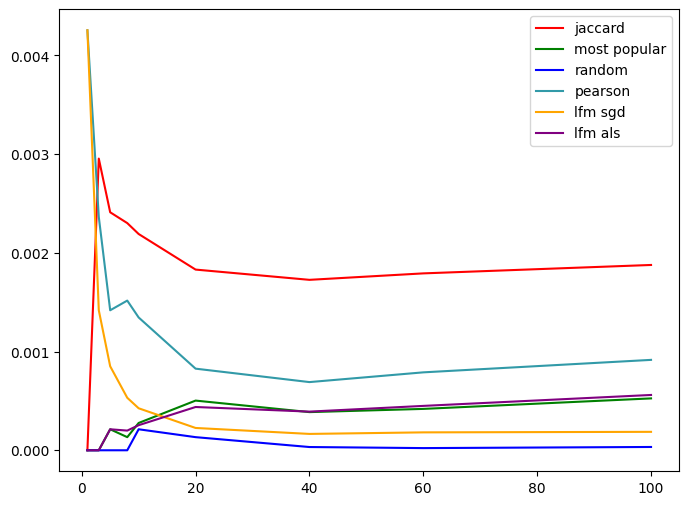

In [62]:
fig = plt.figure(figsize=(8, 6), dpi = 100)

plt.plot(k_grid, mapk_history_jaccard, color='r', label='jaccard')
plt.plot(k_grid, mapk_history_popular, color='g', label='most popular')
plt.plot(k_grid, mapk_history_random, color='b', label='random')
plt.plot(k_grid, mapk_history_pearson, color='#329aa8', label='pearson')
plt.plot(k_grid, mapk_history_lfm_sgd, color ='orange', label = 'lfm sgd')
plt.plot(k_grid, mapk_history_lfm_als, color ='purple', label = 'lfm als')

plt.legend()

fig.show()

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [68]:
model = lfm_als
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q.T @ model.Q.T[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=0) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [70]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q.T[example_trackId])
similar_tracks

,name,artists,similarity
2814,Numb,['Linkin Park'],1.000000
1073,Smells Like Teen Spirit,['Nirvana'],0.999999
805,Zombie,['The Cranberries'],0.999999
24500,Way Down We Go,['KALEO'],0.999999
7533,Highway to Hell,['AC/DC'],0.999999
11493,The Show Must Go On,['Queen'],0.999999
8263,Shape Of My Heart,['Sting'],0.999999
18459,Take Me To Church,['Hozier'],0.999999
6376,"You're Gonna Go Far, Kid",['The Offspring'],0.999999
1019,It's My Life,['Bon Jovi'],0.999999


In [71]:
model = lfm_sgd
example_trackId = tracks_info[tracks_info.name == 'Выхода нет'].iloc[0].id

preds = model.Q.T @ model.Q.T[example_trackId]
preds = preds / np.sqrt((model.Q**2).sum(axis=0) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [72]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q.T[example_trackId])
similar_tracks

,name,artists,similarity
5512,Выхода нет,['Сплин'],1.000000
18234,Happy,['Pharrell Williams'],0.380284
38336,Mio fratello,"['Biagio Antonacci', 'Mario Incudine']",0.375180
64789,И я,['ANAZED'],0.363651
16371,Walking Away,['If I Were You'],0.350445
23395,Sugar Sugar,"['Andrew Rai', 'Alex Dee Gladenko', 'ALLOISE']",0.347285
5771,Котёнок,['Игорь Николаев'],0.344066
11130,Illusion & Dream,['Poets Of The Fall'],0.336009
6750,Four Little Diamonds,['Electric Light Orchestra'],0.328078
52097,Интуиция,['Винтаж'],0.324442


видно, что lfm на базе als просто рекомендует популярное, тогда как sgd lfm выдает более адекватные рекомндации